# **Neural Network and Deep Learning**
# ***Final Project***

------------------------------------------------------
 **Team Members**
 1. Devaraj RAMAMOORTHY
 2. Rubesh PRABAKARAN
 3. Edwin JOHNY PAUL

## Implementing Deep CNN and Diffusion Model in Image Generative Model

Install Required Libraries

In [1]:
pip install torch torchvision matplotlib numpy pillow

Import Libraries

In [2]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

Set Device to GPU

In [3]:
device = torch.device("cuda:1")


Download and Load Sample Image

In [4]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)

Plot Noise Distribution

In [5]:
def plot_noise_distribution(noise, predicted_noise):
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()


Plotting Predictions

In [6]:
def plot_noise_prediction(noise, predicted_noise):
    plt.figure(figsize=(15,15))
    f, ax = plt.subplots(1, 2, figsize = (5,5))
    ax[0].imshow(reverse_transform(noise))
    ax[0].set_title(f"ground truth noise", fontsize = 10)
    ax[1].imshow(reverse_transform(predicted_noise))
    ax[1].set_title(f"predicted noise", fontsize = 10)
    plt.show()

Diffusion Model Class

In [7]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device)


    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns
        the denoised image.
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance
    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

Image Shape

In [8]:
IMAGE_SHAPE = (32, 32)

**Transforms**<br/>

Applies image pre-processing and post-processing (normalization and denormalization with PyTorch transforms).

In [9]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1]
])


reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

Sample Image Transformation

In [10]:
pil_image = get_sample_image()
torch_image = transform(pil_image)

Initialize Diffusion Model

In [11]:
diffusion_model = DiffusionModel()

GPU Check

In [12]:
!nvidia-smi

Sun Apr 13 18:41:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Add Noise Visualization

<Figure size 1500x1500 with 0 Axes>

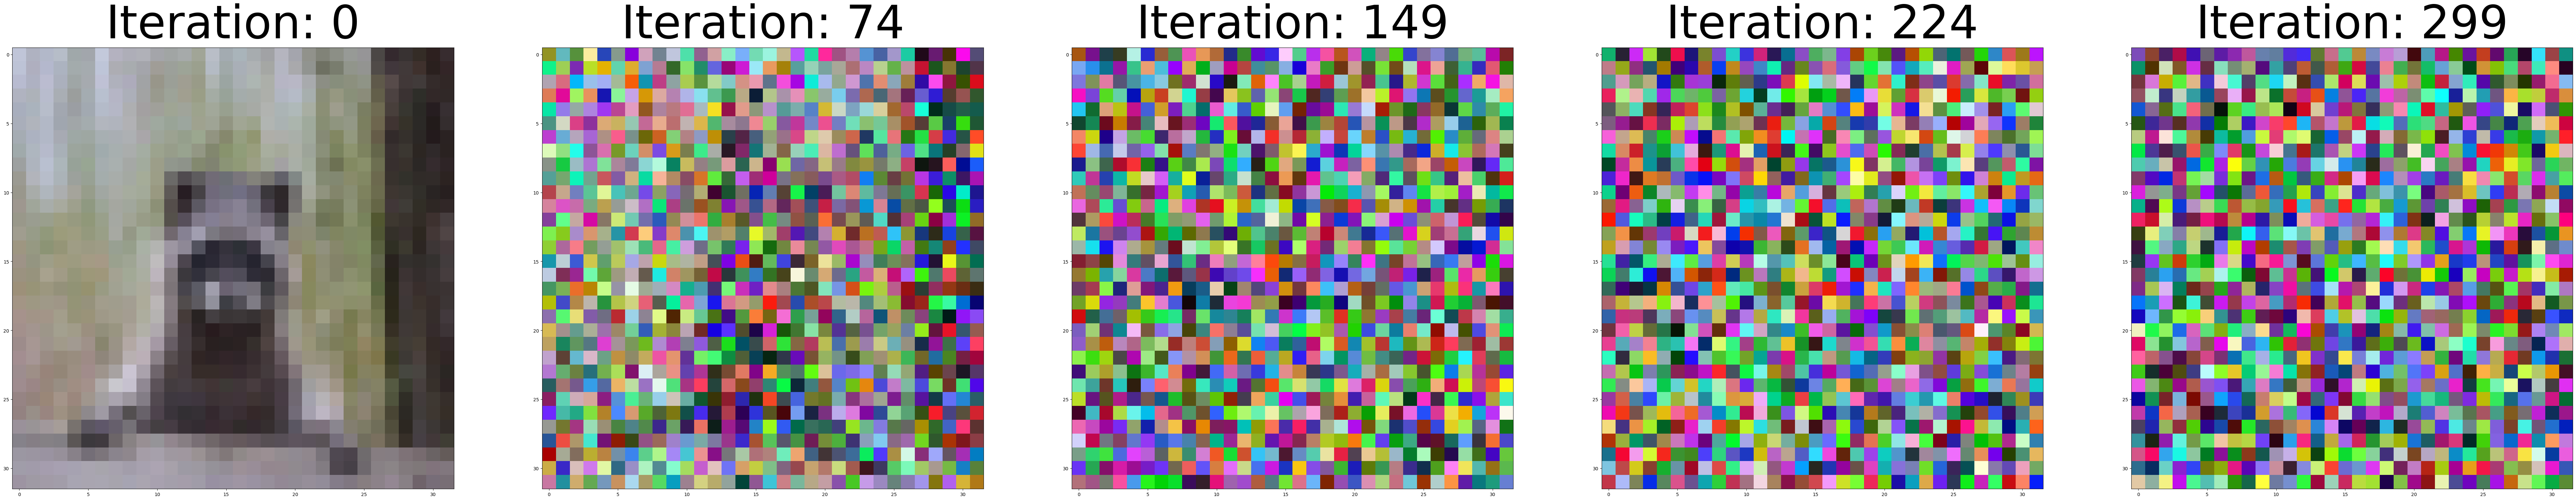

In [14]:
NO_DISPLAY_IMAGES = 5
torch_image_batch = torch.stack([torch_image] * NO_DISPLAY_IMAGES)
t = torch.linspace(0, diffusion_model.timesteps - 1, NO_DISPLAY_IMAGES).long()
noisy_image_batch, _ = diffusion_model.forward(torch_image_batch, t, device)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(1, NO_DISPLAY_IMAGES, figsize = (100,100))

for idx, image in enumerate(noisy_image_batch):
    ax[idx].imshow(reverse_transform(image))
    ax[idx].set_title(f"Iteration: {t[idx].item()}", fontsize = 100)
plt.show()

Positional Embeddings

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

Defines modular building block with optional label conditioning and time embedding.

In [16]:
class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, num_filters = 3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = SinusoidalPositionEmbeddings(time_embedding_dims)
        self.labels = labels
        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv2d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm2d(channels_out)
        self.bnorm2 = nn.BatchNorm2d(channels_out)

        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time[(..., ) + (None, ) * 2]
        if self.labels:
            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label[(..., ) + (None, ) * 2]

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

U-Net Architecture<br/>
A symmetrical encoder-decoder U-Net that uses label and time embeddings, designed to predict noise in input images.

In [17]:
class UNet(nn.Module):
    def __init__(self, img_channels = 3, time_embedding_dims = 128, labels = False, sequence_channels = (64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)

        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels,downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv2d(img_channels, sequence_channels[0], 3, padding=1)
        self.conv2 = nn.Conv2d(sequence_channels[0], img_channels, 1)


    def forward(self, x, t, **kwargs):
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, **kwargs)

        return self.conv2(o)

Training Setup

In [18]:
NO_EPOCHS = 2000
PRINT_FREQUENCY = 400
LR = 0.001
BATCH_SIZE = 128
VERBOSE = True

unet = UNet(labels=False)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

Training Loop (Single Image)<br/>
A loop training the U-Net to predict noise on a replicated sample image using the diffusion model.

---
Epoch: 0 | Train Loss 1.023932695388794


<Figure size 1500x1500 with 0 Axes>

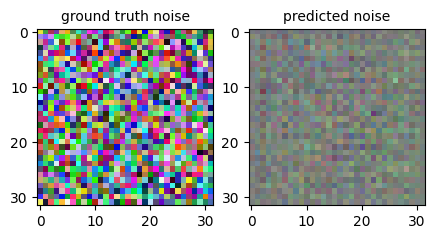

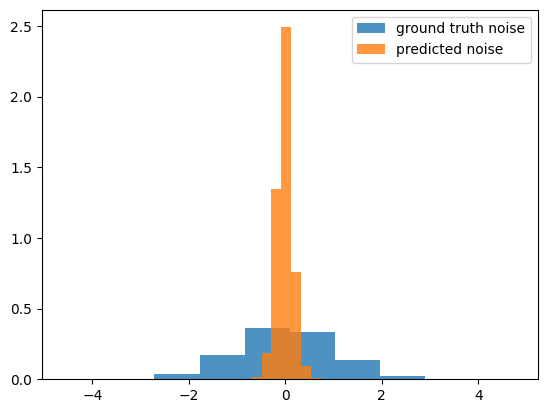

---
Epoch: 400 | Train Loss 0.013650577515363693


<Figure size 1500x1500 with 0 Axes>

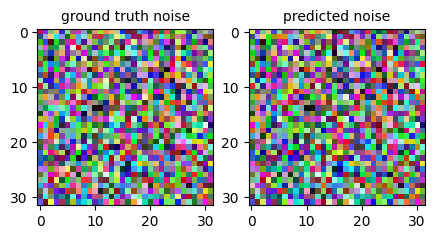

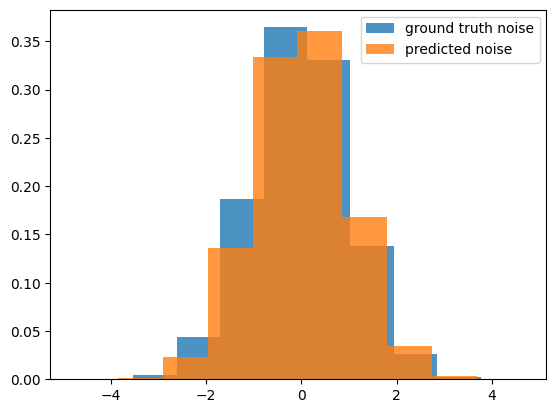

---
Epoch: 800 | Train Loss 0.008712999522686005


<Figure size 1500x1500 with 0 Axes>

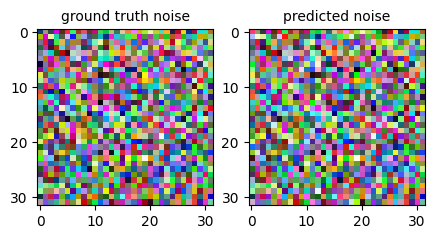

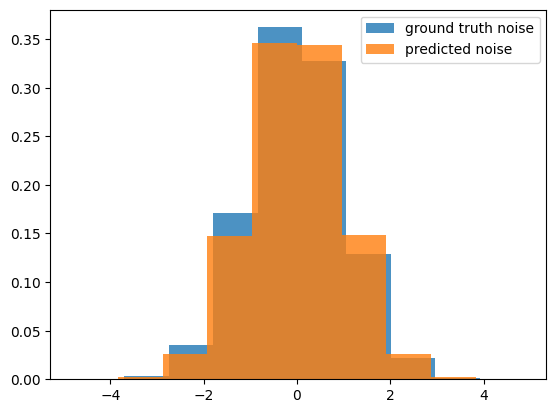

---
Epoch: 1200 | Train Loss 0.014775159768760204


<Figure size 1500x1500 with 0 Axes>

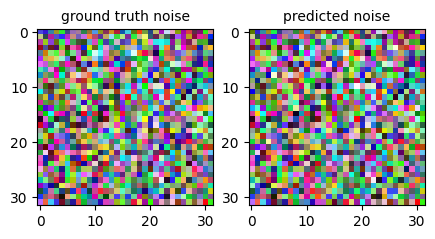

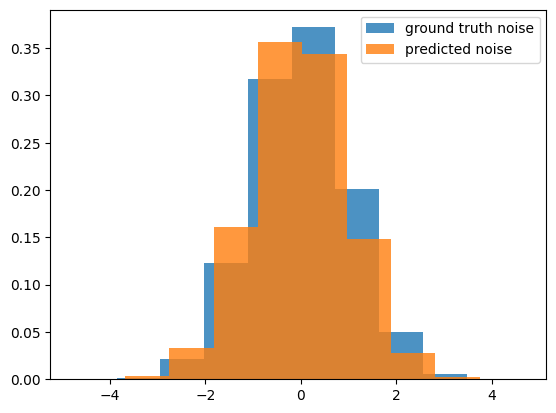

---
Epoch: 1600 | Train Loss 0.008458076044917107


<Figure size 1500x1500 with 0 Axes>

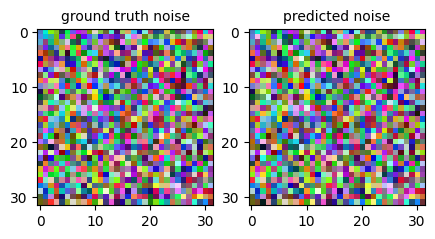

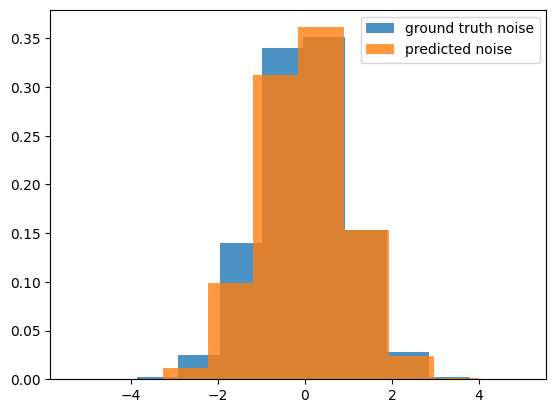

In [19]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []

    batch = torch.stack([torch_image] * BATCH_SIZE)
    t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)

    batch_noisy, noise = diffusion_model.forward(batch, t, device)
    predicted_noise = unet(batch_noisy, t)

    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(noise, predicted_noise)
    mean_epoch_loss.append(loss.item())
    loss.backward()
    optimizer.step()

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

Image Sampling (Unconditional)<br/>
Generates new image(s) by running the backward diffusion process with a trained U-Net.

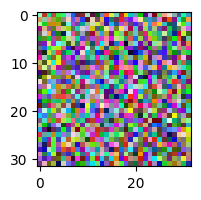

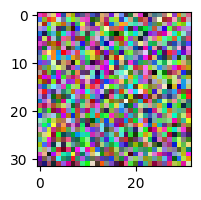

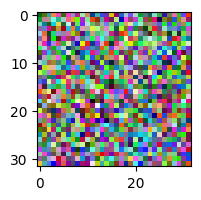

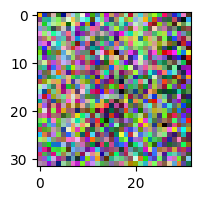

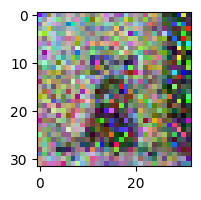

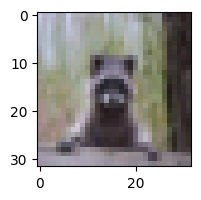

In [20]:
with torch.no_grad():
    img = torch.randn((1, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = diffusion_model.backward(img, t, unet.eval())
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(reverse_transform(img[0]))
            plt.show()


Conditional Setup<br/>
Reinitializes U-Net for label conditioning and loads CIFAR-10 datasets for conditional diffusion training.

In [21]:
BATCH_SIZE = 256
NO_EPOCHS = 20
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = False

unet = UNet(labels=True)
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [22]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Conditional Training Loop<br/>
Train + validation loop where U-Net learns to denoise CIFAR-10 images with labels.

In [23]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    for batch, label in trainloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)
        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    for batch, label in testloader:

        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch = batch.to(device)

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        predicted_noise = unet(batch_noisy, t, labels = label.reshape(-1,1).float().to(device))

        loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_prediction(noise[0], predicted_noise[0])
                plot_noise_distribution(noise, predicted_noise)

        torch.save(unet.state_dict(), f"epoch: {epoch}")


---
Epoch: 0 | Train Loss 0.17790610629778641 | Val Loss 0.08908561712656266
---
Epoch: 10 | Train Loss 0.07042299136519432 | Val Loss 0.0693193334990587


Model Loading<br/>
Loads a specific checkpoint from the training phase.

In [26]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 10")))

<All keys matched successfully>

CIFAR-10 Class Setup<br/>
Lists CIFAR-10 classes and configures image generation counts per class.

In [27]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
NUM_CLASSES = len(classes)
NUM_DISPLAY_IMAGES = 5

Conditional Sampling<br/>
Generates and visualizes samples for each CIFAR-10 class using the trained conditional diffusion model.

In [29]:
torch.manual_seed(16)

plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (100,100))

for c in range(NUM_CLASSES):
    imgs = torch.randn((NUM_DISPLAY_IMAGES, 3) + IMAGE_SHAPE).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([c] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        imgs = diffusion_model.backward(x=imgs, t=t, model=unet.eval().to(device), labels = labels)
    for idx, img in enumerate(imgs):
        ax[c][idx].imshow(reverse_transform(img))
        ax[c][idx].set_title(f"Class: {classes[c]}", fontsize = 100)

plt.show()

/usr/local/lib/python3.11/dist-packages/torch/_tensor.py:1000: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 1500x1500 with 0 Axes>

In [3]:
!jupyter nbconvert "RAMAMOORTHY&PRABAKARAN.ipynb" --to html

[NbConvertApp] Converting notebook RAMAMOORTHY&PRABAKARAN.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 18 image(s).
[NbConvertApp] Writing 2047277 bytes to RAMAMOORTHY&PRABAKARAN.html
